# Warming trend and marine heat waves of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot SST time-series for a Australian Marine Park, and to detect its warming trend and potential marine heat wave events.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th, Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [2]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [3]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2018.**

In [3]:
dc.list_products()

,name,description,time,lat,creation_time,format,label,product_type,instrument,lon,platform,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
5,modis_oc_1d,MODIS Ocean Cover Daily,None,None,None,None,None,modis_oc_1d,None,None,MODIS,EPSG:4326,"(-0.01, 0.01)",None,"(latitude, longitude)"


**Load full time-series of SST (Sea Surface Temperature), for the Lord Howe Marine Park area, from 2002 to 2018. It tooks 5 hours. Note that the resolution has been resampled from 0.01 dd to 0.1 dd to save memory usage.**

In [4]:
data = dc.load(product='modis_oc_1d', lat=(-27,-36), lon=(157,161), resolution=(-0.1, 0.1), measurements=(['sst']))

**Mask the nodata (-999) as 'nan'**

In [5]:
data = mask_invalid_data(data)

In [37]:
# note the time dimension: 5900
data.sst.latitude.size

90

**testDF contains all SST data loaded: 3600 (90 x 40) locations (as columns) with 5900 daily time-series (as rows)**

In [7]:
testDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data.latitude.size:
    while lonIndex < data.longitude.size:
        lat = data.sst[:,latIndex,lonIndex].latitude.values
        lon = data.sst[:,latIndex,lonIndex].longitude.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(id)
        sstData = data.sst[:,latIndex,lonIndex].values
        testDF[id] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
testDF['date'] = dateList
testDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList


In [11]:
testDF.shape

(5900, 3600)

**The pad function interpolate over missing data in a time series. Courtesy of Hobday's marine heat waves codes**

In [12]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


**The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis**

In [13]:
testDF1 = testDF.drop(['20040229','20080229','20120229','20160229'])

**Calculate the dayofyear for each date, and add it to the DataFrame. 
Note that the removal of the Feb 29 dates results in the matching of the dayofyear across years**

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
i = 0
dayofyears = []

while i < testDF1.index.size:
    date = testDF1.index[i]
    year = date[:4]
    ## remove the four Feb 29 in the leap years from the collection
   
    ## calculate dayofyear
    ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
    dayofyear = datetime.strptime(date,'%Y%m%d').timetuple().tm_yday
    if (year == '2004') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2008') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2012') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2016') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    print(date)
    print(dayofyear)

    dayofyears.append(dayofyear)

    i = i + 1
testDF1['dayofyear']=dayofyears



20020704
185
20020705
186
20020706
187
20020707
188
20020708
189
20020709
190
20020710
191
20020711
192
20020712
193
20020713
194
20020714
195
20020715
196
20020716
197
20020717
198
20020718
199
20020719
200
20020720
201
20020721
202
20020722
203
20020723
204
20020724
205
20020725
206
20020726
207
20020727
208
20020728
209
20020729
210
20020807
219
20020808
220
20020809
221
20020810
222
20020811
223
20020812
224
20020813
225
20020814
226
20020815
227
20020816
228
20020817
229
20020818
230
20020819
231
20020820
232
20020821
233
20020822
234
20020823
235
20020824
236
20020825
237
20020826
238
20020827
239
20020828
240
20020829
241
20020830
242
20020831
243
20020901
244
20020902
245
20020903
246
20020904
247
20020905
248
20020906
249
20020907
250
20020908
251
20020909
252
20020910
253
20020911
254
20020912
255
20020913
256
20020914
257
20020915
258
20020916
259
20020917
260
20020918
261
20020919
262
20020920
263
20020921
264
20020922
265
20020923
266
20020924
267
20020925
268
20020926
269

49
20050219
50
20050220
51
20050221
52
20050222
53
20050223
54
20050224
55
20050225
56
20050226
57
20050227
58
20050228
59
20050301
60
20050302
61
20050303
62
20050304
63
20050305
64
20050306
65
20050307
66
20050308
67
20050309
68
20050310
69
20050311
70
20050312
71
20050313
72
20050314
73
20050315
74
20050316
75
20050317
76
20050318
77
20050319
78
20050320
79
20050321
80
20050322
81
20050323
82
20050324
83
20050325
84
20050326
85
20050327
86
20050328
87
20050329
88
20050330
89
20050331
90
20050401
91
20050402
92
20050403
93
20050404
94
20050405
95
20050406
96
20050407
97
20050408
98
20050409
99
20050410
100
20050411
101
20050412
102
20050413
103
20050414
104
20050415
105
20050416
106
20050417
107
20050418
108
20050419
109
20050420
110
20050421
111
20050422
112
20050423
113
20050424
114
20050425
115
20050426
116
20050427
117
20050428
118
20050429
119
20050430
120
20050501
121
20050502
122
20050503
123
20050504
124
20050505
125
20050506
126
20050507
127
20050508
128
20050509
129
2005051

79
20070321
80
20070322
81
20070323
82
20070324
83
20070325
84
20070326
85
20070327
86
20070328
87
20070329
88
20070330
89
20070331
90
20070401
91
20070402
92
20070403
93
20070404
94
20070405
95
20070406
96
20070407
97
20070408
98
20070409
99
20070410
100
20070411
101
20070412
102
20070413
103
20070414
104
20070415
105
20070416
106
20070417
107
20070418
108
20070419
109
20070420
110
20070421
111
20070422
112
20070423
113
20070424
114
20070425
115
20070426
116
20070427
117
20070428
118
20070429
119
20070430
120
20070501
121
20070502
122
20070503
123
20070504
124
20070505
125
20070506
126
20070507
127
20070508
128
20070509
129
20070510
130
20070511
131
20070512
132
20070513
133
20070514
134
20070515
135
20070516
136
20070517
137
20070518
138
20070519
139
20070520
140
20070521
141
20070522
142
20070523
143
20070524
144
20070525
145
20070526
146
20070527
147
20070528
148
20070529
149
20070530
150
20070531
151
20070601
152
20070603
154
20070604
155
20070605
156
20070606
157
20070607
158
200

20091209
343
20091210
344
20091211
345
20091212
346
20091213
347
20091214
348
20091215
349
20091216
350
20091217
351
20091218
352
20091219
353
20091220
354
20091221
355
20091222
356
20091223
357
20091224
358
20091225
359
20091226
360
20091227
361
20091228
362
20091229
363
20091230
364
20091231
365
20100101
1
20100102
2
20100103
3
20100104
4
20100105
5
20100106
6
20100107
7
20100108
8
20100109
9
20100110
10
20100111
11
20100112
12
20100113
13
20100114
14
20100115
15
20100116
16
20100117
17
20100118
18
20100119
19
20100120
20
20100121
21
20100122
22
20100123
23
20100124
24
20100125
25
20100126
26
20100127
27
20100128
28
20100129
29
20100130
30
20100131
31
20100201
32
20100202
33
20100203
34
20100204
35
20100205
36
20100206
37
20100207
38
20100208
39
20100209
40
20100210
41
20100211
42
20100212
43
20100213
44
20100214
45
20100215
46
20100216
47
20100217
48
20100218
49
20100219
50
20100220
51
20100221
52
20100222
53
20100223
54
20100224
55
20100225
56
20100226
57
20100227
58
20100228
59
20

20111010
283
20111011
284
20111012
285
20111013
286
20111014
287
20111015
288
20111016
289
20111017
290
20111018
291
20111019
292
20111020
293
20111021
294
20111022
295
20111023
296
20111024
297
20111025
298
20111026
299
20111027
300
20111028
301
20111029
302
20111030
303
20111031
304
20111101
305
20111102
306
20111103
307
20111104
308
20111105
309
20111106
310
20111107
311
20111108
312
20111109
313
20111110
314
20111111
315
20111112
316
20111113
317
20111114
318
20111115
319
20111116
320
20111117
321
20111118
322
20111119
323
20111120
324
20111121
325
20111122
326
20111123
327
20111124
328
20111125
329
20111126
330
20111127
331
20111128
332
20111129
333
20111130
334
20111201
335
20111202
336
20111203
337
20111204
338
20111205
339
20111206
340
20111207
341
20111208
342
20111209
343
20111210
344
20111211
345
20111212
346
20111213
347
20111214
348
20111215
349
20111216
350
20111217
351
20111218
352
20111219
353
20111220
354
20111221
355
20111222
356
20111223
357
20111224
358
20111225
359

123
20140504
124
20140505
125
20140506
126
20140507
127
20140508
128
20140509
129
20140510
130
20140511
131
20140512
132
20140513
133
20140514
134
20140515
135
20140516
136
20140517
137
20140518
138
20140519
139
20140520
140
20140521
141
20140522
142
20140523
143
20140524
144
20140525
145
20140526
146
20140527
147
20140528
148
20140529
149
20140530
150
20140531
151
20140601
152
20140602
153
20140603
154
20140604
155
20140605
156
20140606
157
20140607
158
20140608
159
20140609
160
20140610
161
20140611
162
20140612
163
20140613
164
20140614
165
20140615
166
20140616
167
20140617
168
20140618
169
20140619
170
20140620
171
20140621
172
20140622
173
20140623
174
20140624
175
20140625
176
20140626
177
20140627
178
20140628
179
20140629
180
20140630
181
20140701
182
20140702
183
20140703
184
20140704
185
20140705
186
20140706
187
20140707
188
20140708
189
20140709
190
20140710
191
20140711
192
20140712
193
20140713
194
20140714
195
20140715
196
20140716
197
20140717
198
20140718
199
20140719

20180408
98
20180409
99
20180410
100
20180411
101
20180412
102
20180413
103
20180414
104
20180415
105
20180416
106
20180417
107
20180418
108
20180419
109
20180420
110
20180421
111
20180422
112
20180423
113
20180424
114
20180425
115
20180426
116
20180427
117
20180428
118
20180429
119
20180430
120
20180501
121
20180502
122
20180503
123
20180504
124
20180505
125
20180506
126
20180507
127
20180508
128
20180509
129
20180510
130
20180511
131
20180512
132
20180513
133
20180514
134
20180515
135
20180516
136
20180517
137
20180518
138
20180519
139
20180520
140
20180521
141
20180522
142
20180523
143
20180524
144
20180525
145
20180526
146
20180527
147
20180528
148
20180529
149
20180530
150
20180531
151
20180601
152
20180602
153
20180603
154
20180604
155
20180605
156
20180606
157
20180607
158
20180608
159
20180609
160
20180610
161
20180611
162
20180612
163
20180613
164
20180614
165
20180615
166
20180616
167
20180617
168
20180618
169
20180619
170
20180620
171
20180621
172
20180622
173
20180623
174
2

In [15]:
testDF1.columns.size

3601

**The testIDF1 is generated from testDF1 after applying the interpolation (pad) function**

In [16]:
testIDF1 = pd.DataFrame()
interpolatedSSTList = []
i = 1
while i < testDF1.columns.size:
    sst = testDF1[i].values
    interpolatedSST = pad(sst,maxPadLength=2)
    testIDF1[i] = interpolatedSST
    i += 1
testIDF1['date'] = testDF1.index
testIDF1['dayofyear'] = testDF1['dayofyear'].values
testIDF1.set_index('date', inplace=True)

In [17]:
testIDF1.columns.size

3601

**The nintypercentile function**

In [18]:
def nintypercentile(x):
    z = x.quantile(0.9)
    return(z)


**The 90 percentile is used as the threshold to identify the MHWs.
The SST values of the same dayofyear are grouped. The 90 percentile is then calculated for each group**

In [99]:
# 90th percentile from testIDF1
nintyDF = pd.DataFrame()

i = 1
while i < 3601:
    print(str(i))
    sst_series_g = testIDF1[i].groupby(testIDF1['dayofyear'])
    sst_90 = sst_series_g.transform(nintypercentile)
    nintyDF[i] = sst_90
    i += 1
nintyDF['date'] = testDF1.index
nintyDF['dayofyear'] = testDF1['dayofyear'].values
nintyDF.set_index('date', inplace=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600


**Another way of calculating the 90 perentile threshold. This time uses a 11-days window so that 
we have a much larger number of SST values each date from which to calculate the 90 percentile.
This also smoothes the 90 percentile climatology to a large degree.**

In [353]:
# 90th percentile with 11-days window
# this one takes too long to complete
nintyDF1 = pd.DataFrame()
i = 1

while i < 3601:
    print(str(i))
    nintyList = []
    for date in testIDF1.index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF1[i] = nintyList
    i += 1
nintyDF1['date'] = testDF1.index
nintyDF1['dayofyear'] = testDF1['dayofyear'].values
nintyDF1.set_index('date', inplace=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600


**More efficient codes to calculate the 90 percentile climatology data with 11-days window are shown 
in the next few cells**

In [19]:
# 90th percentile with 11-days window
# this one takes much shorter to complete, as it only runs for one year cycle
nintyDF2 = pd.DataFrame()
i = 1

while i < 3601:
    print(str(i))
    nintyList = []
    dayofyearList = []
    for date in testIDF1.loc['20030101':'20031231'].index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF2[i] = nintyList
    i += 1
#nintyDF2['date'] = testDF1.index
nintyDF2['dayofyear'] = dayofyearList
nintyDF2.set_index('dayofyear', inplace=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600


In [20]:
nintyDF3 = testIDF1.copy(deep=True)

In [21]:
for date in nintyDF3.index:
    print(date)
    dayofyear = nintyDF3.dayofyear.loc[date]
    print(dayofyear)
    for doy in nintyDF2.index:
        if dayofyear == doy:
            nintyDF3.loc[date] = nintyDF2.loc[doy]
            nintyDF3.dayofyear.loc[date] = str(dayofyear)
    


20020704
185


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


20020705
186.0
20020706
187.0
20020707
188.0
20020708
189.0
20020709
190.0
20020710
191.0
20020711
192.0
20020712
193.0
20020713
194.0
20020714
195.0
20020715
196.0
20020716
197.0
20020717
198.0
20020718
199.0
20020719
200.0
20020720
201.0
20020721
202.0
20020722
203.0
20020723
204.0
20020724
205.0
20020725
206.0
20020726
207.0
20020727
208.0
20020728
209.0
20020729
210.0
20020807
219.0
20020808
220.0
20020809
221.0
20020810
222.0
20020811
223.0
20020812
224.0
20020813
225.0
20020814
226.0
20020815
227.0
20020816
228.0
20020817
229.0
20020818
230.0
20020819
231.0
20020820
232.0
20020821
233.0
20020822
234.0
20020823
235.0
20020824
236.0
20020825
237.0
20020826
238.0
20020827
239.0
20020828
240.0
20020829
241.0
20020830
242.0
20020831
243.0
20020901
244.0
20020902
245.0
20020903
246.0
20020904
247.0
20020905
248.0
20020906
249.0
20020907
250.0
20020908
251.0
20020909
252.0
20020910
253.0
20020911
254.0
20020912
255.0
20020913
256.0
20020914
257.0
20020915
258.0
20020916
259.0
20020917
2

20040120
20.0
20040121
21.0
20040122
22.0
20040123
23.0
20040124
24.0
20040125
25.0
20040126
26.0
20040127
27.0
20040128
28.0
20040129
29.0
20040130
30.0
20040131
31.0
20040201
32.0
20040202
33.0
20040203
34.0
20040204
35.0
20040205
36.0
20040206
37.0
20040207
38.0
20040208
39.0
20040209
40.0
20040210
41.0
20040211
42.0
20040212
43.0
20040213
44.0
20040214
45.0
20040215
46.0
20040216
47.0
20040217
48.0
20040218
49.0
20040219
50.0
20040220
51.0
20040221
52.0
20040222
53.0
20040223
54.0
20040224
55.0
20040225
56.0
20040226
57.0
20040227
58.0
20040228
59.0
20040301
60.0
20040302
61.0
20040303
62.0
20040304
63.0
20040305
64.0
20040306
65.0
20040307
66.0
20040308
67.0
20040309
68.0
20040310
69.0
20040311
70.0
20040312
71.0
20040313
72.0
20040314
73.0
20040315
74.0
20040316
75.0
20040317
76.0
20040318
77.0
20040319
78.0
20040320
79.0
20040321
80.0
20040322
81.0
20040323
82.0
20040324
83.0
20040325
84.0
20040326
85.0
20040327
86.0
20040328
87.0
20040329
88.0
20040330
89.0
20040331
90.0
200404

20050803
215.0
20050804
216.0
20050805
217.0
20050806
218.0
20050807
219.0
20050808
220.0
20050809
221.0
20050810
222.0
20050811
223.0
20050812
224.0
20050813
225.0
20050814
226.0
20050815
227.0
20050816
228.0
20050817
229.0
20050818
230.0
20050819
231.0
20050820
232.0
20050821
233.0
20050822
234.0
20050823
235.0
20050824
236.0
20050825
237.0
20050826
238.0
20050827
239.0
20050828
240.0
20050829
241.0
20050830
242.0
20050831
243.0
20050901
244.0
20050902
245.0
20050903
246.0
20050904
247.0
20050905
248.0
20050906
249.0
20050907
250.0
20050908
251.0
20050909
252.0
20050910
253.0
20050911
254.0
20050912
255.0
20050913
256.0
20050914
257.0
20050915
258.0
20050916
259.0
20050917
260.0
20050918
261.0
20050919
262.0
20050920
263.0
20050921
264.0
20050922
265.0
20050923
266.0
20050924
267.0
20050925
268.0
20050926
269.0
20050927
270.0
20050928
271.0
20050929
272.0
20050930
273.0
20051001
274.0
20051002
275.0
20051003
276.0
20051004
277.0
20051005
278.0
20051006
279.0
20051007
280.0
20051008
2

20070212
43.0
20070213
44.0
20070214
45.0
20070215
46.0
20070216
47.0
20070217
48.0
20070218
49.0
20070219
50.0
20070220
51.0
20070221
52.0
20070222
53.0
20070223
54.0
20070224
55.0
20070225
56.0
20070226
57.0
20070227
58.0
20070228
59.0
20070301
60.0
20070302
61.0
20070303
62.0
20070304
63.0
20070305
64.0
20070306
65.0
20070307
66.0
20070308
67.0
20070309
68.0
20070310
69.0
20070311
70.0
20070312
71.0
20070313
72.0
20070314
73.0
20070315
74.0
20070316
75.0
20070317
76.0
20070318
77.0
20070319
78.0
20070320
79.0
20070321
80.0
20070322
81.0
20070323
82.0
20070324
83.0
20070325
84.0
20070326
85.0
20070327
86.0
20070328
87.0
20070329
88.0
20070330
89.0
20070331
90.0
20070401
91.0
20070402
92.0
20070403
93.0
20070404
94.0
20070405
95.0
20070406
96.0
20070407
97.0
20070408
98.0
20070409
99.0
20070410
100.0
20070411
101.0
20070412
102.0
20070413
103.0
20070414
104.0
20070415
105.0
20070416
106.0
20070417
107.0
20070418
108.0
20070419
109.0
20070420
110.0
20070421
111.0
20070422
112.0
2007042

20080826
238.0
20080827
239.0
20080828
240.0
20080829
241.0
20080830
242.0
20080831
243.0
20080901
244.0
20080902
245.0
20080903
246.0
20080904
247.0
20080905
248.0
20080906
249.0
20080907
250.0
20080908
251.0
20080909
252.0
20080910
253.0
20080911
254.0
20080912
255.0
20080913
256.0
20080914
257.0
20080915
258.0
20080916
259.0
20080917
260.0
20080918
261.0
20080919
262.0
20080920
263.0
20080921
264.0
20080922
265.0
20080923
266.0
20080924
267.0
20080925
268.0
20080926
269.0
20080927
270.0
20080928
271.0
20080929
272.0
20080930
273.0
20081001
274.0
20081002
275.0
20081003
276.0
20081004
277.0
20081005
278.0
20081006
279.0
20081007
280.0
20081008
281.0
20081009
282.0
20081010
283.0
20081011
284.0
20081012
285.0
20081013
286.0
20081014
287.0
20081015
288.0
20081016
289.0
20081017
290.0
20081018
291.0
20081019
292.0
20081020
293.0
20081021
294.0
20081022
295.0
20081023
296.0
20081024
297.0
20081025
298.0
20081026
299.0
20081027
300.0
20081028
301.0
20081029
302.0
20081030
303.0
20081031
3

20100309
68.0
20100310
69.0
20100311
70.0
20100312
71.0
20100313
72.0
20100314
73.0
20100315
74.0
20100316
75.0
20100317
76.0
20100318
77.0
20100319
78.0
20100320
79.0
20100321
80.0
20100322
81.0
20100323
82.0
20100324
83.0
20100325
84.0
20100326
85.0
20100327
86.0
20100328
87.0
20100329
88.0
20100330
89.0
20100331
90.0
20100401
91.0
20100402
92.0
20100403
93.0
20100404
94.0
20100405
95.0
20100406
96.0
20100407
97.0
20100408
98.0
20100409
99.0
20100410
100.0
20100411
101.0
20100412
102.0
20100413
103.0
20100414
104.0
20100415
105.0
20100416
106.0
20100417
107.0
20100418
108.0
20100419
109.0
20100420
110.0
20100421
111.0
20100422
112.0
20100423
113.0
20100424
114.0
20100425
115.0
20100426
116.0
20100427
117.0
20100428
118.0
20100429
119.0
20100430
120.0
20100501
121.0
20100502
122.0
20100503
123.0
20100504
124.0
20100505
125.0
20100506
126.0
20100507
127.0
20100508
128.0
20100509
129.0
20100510
130.0
20100511
131.0
20100512
132.0
20100513
133.0
20100514
134.0
20100515
135.0
20100516
136

20110916
259.0
20110917
260.0
20110918
261.0
20110919
262.0
20110920
263.0
20110921
264.0
20110922
265.0
20110923
266.0
20110924
267.0
20110925
268.0
20110926
269.0
20110927
270.0
20110928
271.0
20110929
272.0
20110930
273.0
20111001
274.0
20111002
275.0
20111003
276.0
20111004
277.0
20111005
278.0
20111006
279.0
20111007
280.0
20111008
281.0
20111009
282.0
20111010
283.0
20111011
284.0
20111012
285.0
20111013
286.0
20111014
287.0
20111015
288.0
20111016
289.0
20111017
290.0
20111018
291.0
20111019
292.0
20111020
293.0
20111021
294.0
20111022
295.0
20111023
296.0
20111024
297.0
20111025
298.0
20111026
299.0
20111027
300.0
20111028
301.0
20111029
302.0
20111030
303.0
20111031
304.0
20111101
305.0
20111102
306.0
20111103
307.0
20111104
308.0
20111105
309.0
20111106
310.0
20111107
311.0
20111108
312.0
20111109
313.0
20111110
314.0
20111111
315.0
20111112
316.0
20111113
317.0
20111114
318.0
20111115
319.0
20111116
320.0
20111117
321.0
20111118
322.0
20111119
323.0
20111120
324.0
20111121
3

20130330
89.0
20130331
90.0
20130401
91.0
20130402
92.0
20130403
93.0
20130404
94.0
20130405
95.0
20130406
96.0
20130407
97.0
20130408
98.0
20130409
99.0
20130410
100.0
20130411
101.0
20130412
102.0
20130413
103.0
20130414
104.0
20130415
105.0
20130416
106.0
20130417
107.0
20130418
108.0
20130419
109.0
20130420
110.0
20130421
111.0
20130422
112.0
20130423
113.0
20130424
114.0
20130425
115.0
20130426
116.0
20130427
117.0
20130428
118.0
20130429
119.0
20130430
120.0
20130501
121.0
20130502
122.0
20130503
123.0
20130504
124.0
20130505
125.0
20130506
126.0
20130507
127.0
20130508
128.0
20130509
129.0
20130510
130.0
20130511
131.0
20130512
132.0
20130513
133.0
20130514
134.0
20130515
135.0
20130516
136.0
20130517
137.0
20130518
138.0
20130519
139.0
20130520
140.0
20130521
141.0
20130522
142.0
20130523
143.0
20130524
144.0
20130525
145.0
20130526
146.0
20130527
147.0
20130528
148.0
20130529
149.0
20130530
150.0
20130531
151.0
20130601
152.0
20130602
153.0
20130603
154.0
20130604
155.0
201306

20141006
279.0
20141007
280.0
20141008
281.0
20141009
282.0
20141010
283.0
20141011
284.0
20141012
285.0
20141013
286.0
20141014
287.0
20141015
288.0
20141016
289.0
20141017
290.0
20141018
291.0
20141019
292.0
20141020
293.0
20141021
294.0
20141022
295.0
20141023
296.0
20141024
297.0
20141025
298.0
20141026
299.0
20141027
300.0
20141028
301.0
20141029
302.0
20141030
303.0
20141031
304.0
20141101
305.0
20141102
306.0
20141103
307.0
20141104
308.0
20141105
309.0
20141106
310.0
20141107
311.0
20141108
312.0
20141109
313.0
20141110
314.0
20141111
315.0
20141112
316.0
20141113
317.0
20141114
318.0
20141115
319.0
20141116
320.0
20141117
321.0
20141118
322.0
20141119
323.0
20141120
324.0
20141121
325.0
20141122
326.0
20141123
327.0
20141124
328.0
20141125
329.0
20141126
330.0
20141127
331.0
20141128
332.0
20141129
333.0
20141130
334.0
20141201
335.0
20141202
336.0
20141203
337.0
20141204
338.0
20141205
339.0
20141206
340.0
20141207
341.0
20141208
342.0
20141209
343.0
20141210
344.0
20141211
3

20160420
110.0
20160421
111.0
20160422
112.0
20160423
113.0
20160424
114.0
20160425
115.0
20160426
116.0
20160427
117.0
20160428
118.0
20160429
119.0
20160430
120.0
20160501
121.0
20160502
122.0
20160503
123.0
20160504
124.0
20160505
125.0
20160506
126.0
20160507
127.0
20160508
128.0
20160509
129.0
20160510
130.0
20160511
131.0
20160512
132.0
20160513
133.0
20160514
134.0
20160515
135.0
20160516
136.0
20160517
137.0
20160518
138.0
20160519
139.0
20160520
140.0
20160521
141.0
20160522
142.0
20160523
143.0
20160524
144.0
20160525
145.0
20160526
146.0
20160527
147.0
20160528
148.0
20160529
149.0
20160530
150.0
20160531
151.0
20160601
152.0
20160602
153.0
20160603
154.0
20160604
155.0
20160605
156.0
20160606
157.0
20160607
158.0
20160608
159.0
20160609
160.0
20160610
161.0
20160611
162.0
20160612
163.0
20160613
164.0
20160614
165.0
20160615
166.0
20160616
167.0
20160617
168.0
20160618
169.0
20160619
170.0
20160620
171.0
20160621
172.0
20160622
173.0
20160623
174.0
20160624
175.0
20160625
1

20171027
300.0
20171028
301.0
20171029
302.0
20171030
303.0
20171031
304.0
20171101
305.0
20171102
306.0
20171103
307.0
20171104
308.0
20171105
309.0
20171106
310.0
20171107
311.0
20171108
312.0
20171109
313.0
20171110
314.0
20171111
315.0
20171112
316.0
20171113
317.0
20171114
318.0
20171115
319.0
20171116
320.0
20171117
321.0
20171118
322.0
20171119
323.0
20171120
324.0
20171121
325.0
20171122
326.0
20171123
327.0
20171124
328.0
20171125
329.0
20171126
330.0
20171127
331.0
20171128
332.0
20171129
333.0
20171130
334.0
20171201
335.0
20171202
336.0
20171203
337.0
20171204
338.0
20171205
339.0
20171206
340.0
20171207
341.0
20171208
342.0
20171209
343.0
20171210
344.0
20171211
345.0
20171212
346.0
20171213
347.0
20171214
348.0
20171215
349.0
20171216
350.0
20171217
351.0
20171218
352.0
20171219
353.0
20171220
354.0
20171221
355.0
20171222
356.0
20171223
357.0
20171224
358.0
20171225
359.0
20171226
360.0
20171227
361.0
20171228
362.0
20171229
363.0
20171230
364.0
20171231
365.0
20180201
3

**We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

In [22]:
nintyDF4 = nintyDF3.copy(deep=True)

In [23]:
nintyDF4 = nintyDF4.rolling(31,center=True).mean()

In [24]:
nintyDF4['dayofyear'] = nintyDF3.dayofyear

**Calculate the SST anomalies (differences) between the SST values and the 90 percentile data**

In [94]:
diffDF = pd.DataFrame()

i = 1
while i < 3601:
    diff = testIDF1[i] - nintyDF[i]
    diffDF[i] = diff
    i += 1
diffDF['date'] = testDF1.index
diffDF.set_index('date', inplace=True)

In [362]:
diffDF1 = pd.DataFrame()

i = 1
while i < 3601:
    diff = testIDF1[i] - nintyDF1[i]
    diffDF1[i] = diff
    i += 1
diffDF1['date'] = testDF1.index
diffDF1.set_index('date', inplace=True)

In [32]:
diffDF3 = pd.DataFrame()

i = 1
while i < 3601:
    diff = testIDF1[i] - nintyDF3[i]
    diffDF3[i] = diff
    i += 1
diffDF3['date'] = testDF1.index
diffDF3.set_index('date', inplace=True)

In [25]:
diffDF4 = pd.DataFrame()

i = 1
while i < 3601:
    diff = testIDF1[i] - nintyDF4[i]
    diffDF4[i] = diff
    i += 1
diffDF4['date'] = testDF1.index
diffDF4.set_index('date', inplace=True)

**plot the two 90 percentile dataset together. One is from 11-days window; the other illustrates further 
smooth using 31-days running average.**

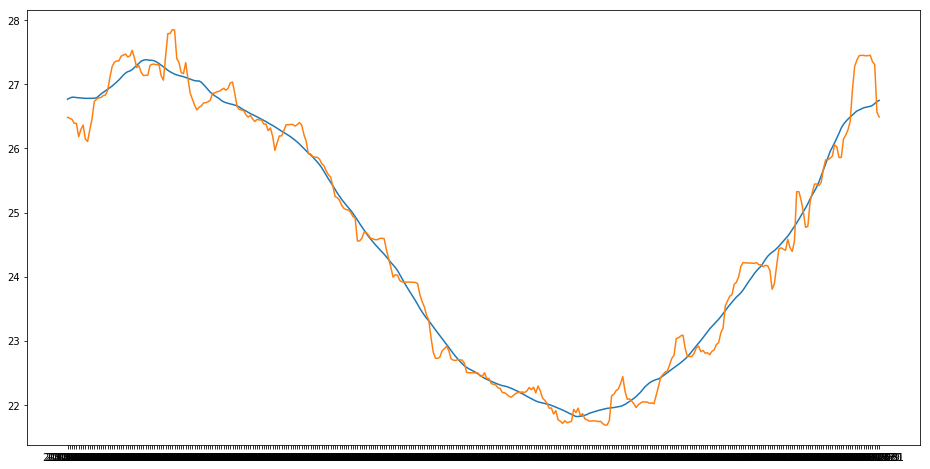

In [26]:
fig = plt.figure(figsize=(16,8))
plt.plot(nintyDF4.loc['20120101':'20121231'][1])
plt.plot(nintyDF3.loc['20120101':'20121231'][1])

**The main function to identify the MHW events and generate statistics. Return two dataframes. 
One contains the summary statistics. The other contains the intensity of the MHW days, so that we can 
generate daily spatial statistics. The function also saves individual MHW files and the summary statistics file.** 

In [27]:
import sys
import os
import numpy as np
from scipy.ndimage import label
import pandas as pd
from datetime import datetime

def do_analysis(sstDiff_data,lonlatDF,amp,outDir):
    
    print(datetime.now())
   
    
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    #mhwEList = []
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    statsDF = pd.DataFrame()
    statsDF['date'] = sstDiff_data.index
    statsDF.set_index('date',inplace=True)
    


   
    # loop through each Point
    for id in sstDiff_data.columns:
        print(str(id))
        idList.append(id)
        # create a dataframe to store characteristics of the MHWs events identified for this point
        mhwE = pd.DataFrame()
        date_start = []
        date_end = []
        duration = []

        # get the point values as a numpy array, the empty value is NaN
        point1 = sstDiff_data[id]
        point1V = point1.values
        dates = sstDiff_data.index.values

        # replace the NaN values with '-9999'
        point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
        # convert negative values into 0 and positive values into 1
        point1V_1[point1V_1<=0] = False
        point1V_1[point1V_1>0] = True
        # label events: positive value(s)
       
        events, n_events = label(point1V_1)
        #print(events)
        #print(n_events)
        for ev in range(1,n_events+1):
            # calculate duration of an event
            event_duration = (events == ev).sum()
            # initially identify all events with duration of 4+ days
            # isolated 4-day event(s) will be eventually removed
            if event_duration > 3:

                date_start.append(dates[np.where(events == ev)[0][0]])
                date_end.append(dates[np.where(events == ev)[0][-1]])
                duration.append(event_duration)
        # the initial list of mhwE
        mhwE['date_start'] = date_start
        mhwE['date_end'] = date_end
        mhwE['duration'] = duration

        # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
        i = 0
        while i < mhwE.index.size - 1:

            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            gap = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if gap < 3:
                # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            elif gap < 4:
                # condition 4: [>=5 hot, 2 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            else:
                i = i + 1

        # drop the isolated event(s) with a duration of 4 days from the list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if duration == 4:
                mhwE = mhwE.drop(i)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1

        # update the durations of the final list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            mhwE['duration'][i] = duration
            i = i + 1

        # calculate mhw properties: intensity max, intensity mean, intensity std, 
        # cumulative intensity, onset rate and decline rate
        intensity_max = []
        intensity_mean = []
        intensity_std = []
        intensity_cumulative = []

        onset_rate = []
        decline_rate = []
        i = 0
      
        while i < mhwE.index.size:
            intensity_values = []
            date_values = []
            startDate = mhwE.iloc[i]['date_start']
            endDate = mhwE.iloc[i]['date_end']
            duration = mhwE.iloc[i]['duration']

            j = 0
            while j < sstDiff_data.index.size:

                date1 = dates[j]
                if startDate == date1:
                    k = j + int(duration)

                    while j < k:

                        sst_diff = point1V[j]
                        intensity_values.append(sst_diff)
                        dateV = dates[j]
                        date_values.append(dateV)
                        j = j + 1
                else:
                    j = j + 1
            #print('event', i, ':', intensity_values)
            np_intensity = np.array(intensity_values)
            np_date = np.array(date_values)

            startDiff = np_intensity[0]
            endDiff = np_intensity[-1]
            maxDiff = np_intensity.max()
            meanDiff = np_intensity.mean()
            stdDiff = np_intensity.std()
            cumDiff = np_intensity.sum()
      
            peakDate = np_date[np_intensity == maxDiff][0]

            dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                        datetime.strptime(str(startDate),'%Y%m%d')).days
            if dateDiff1 > 0:        
                rateOnset = (maxDiff - startDiff) / dateDiff1
            else: # the start date is the peak date
                rateOnset = maxDiff / 0.5

            dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                        datetime.strptime(str(peakDate),'%Y%m%d')).days
            if dateDiff2 > 0:        
                rateDecline = (maxDiff - endDiff) / dateDiff2
            else: # the end date is the peak date
                rateDecline = maxDiff / 0.5


            intensity_max.append(maxDiff)
            intensity_mean.append(meanDiff)
            intensity_std.append(stdDiff)
            intensity_cumulative.append(cumDiff)

            onset_rate.append(rateOnset)
            decline_rate.append(rateDecline)
            i = i + 1

        mhwE['maxIntensity'] = intensity_max
        mhwE['meanIntensity'] = intensity_mean
        mhwE['stdIntensity'] = intensity_std
        mhwE['cumIntensity'] = intensity_cumulative

        mhwE['onsetRate'] = onset_rate
        mhwE['declineRate'] = decline_rate

        # save the MHWs events identified for the point into a CSV file
        filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
        mhwE.to_csv(filename, sep=',', index=False)
        
        
        # generate a statsDF to extract the intensity for the days identified as part of a MHW
        if mhwE.index.size > 0:
            statsDF[str(id)] = np.nan
            for j in mhwE.index:    
                date_start = str(int(mhwE.loc[j]['date_start']))
                date_end = str(int(mhwE.loc[j]['date_end']))
                statsDF.loc[date_start:date_end,str(id)] = sstDiff_data.loc[date_start:date_end][id].values
         

    #   geneate the summary characteristics of the MHWs    
    #    mhwEList.append(mhwE)
        if mhwE.index.size > 0:

            noEvents.append(mhwE.index.size)
            noDays.append(mhwE['duration'].sum())
            totalIntensity.append(mhwE['cumIntensity'].sum())
            overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())

            tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
            HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
            HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
            highestIntensity.append(mhwE['maxIntensity'].max())
            date_start_HI.append(HIDate)
            duration_HI.append(HIDuration)

            tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
            LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
            largestDuration.append(mhwE['duration'].max())
            date_start_LD.append(LDDate)
            intensityLD.append(intensityLDV)


            tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
            LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
            largestMeanIntensity.append(mhwE['meanIntensity'].max())
            date_start_LMI.append(LMIDate)
            duration_LMI.append(LMIDuration)    


            tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
            LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
            largestCumIntensity.append(mhwE['cumIntensity'].max())
            date_start_LCI.append(LCIDate)
            duration_LCI.append(LCIDuration)
        else:
            noEvents.append(0)
            noDays.append(0)
            totalIntensity.append(0)
            overallIntensity.append(0)

            highestIntensity.append(0)
            date_start_HI.append(0)
            duration_HI.append(0)


            largestDuration.append(0)
            date_start_LD.append(0)
            intensityLD.append(0)


            largestMeanIntensity.append(0)
            date_start_LMI.append(0)
            duration_LMI.append(0)

            largestCumIntensity.append(0)
            date_start_LCI.append(0)
            duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList
    mhwDF1['lat'] = latlonDF.lat.values
    mhwDF1['lon'] = latlonDF.lon.values
    #mhwDF1['MHWs'] = mhwEList
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
    print(datetime.now())
    return mhwDF1, statsDF


**Apply the main function**

In [169]:
outdir = '/home/547/zxh547/dea-notebooks/mhw'
amp = 'LH'
mhwDF, statsDF = do_analysis(diffDF,amp,outdir)

2019-04-10 16:28:53.151531
1


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
2019-04-10 17:42:51.033958


In [372]:
outdir = '/home/547/zxh547/dea-notebooks/mhw_1'
amp = 'LH1'
mhwDF1, statsDF1 = do_analysis(diffDF1,amp,outdir)

2019-04-15 08:53:51.873356
1


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
2019-04-15 09:49:59.904956


In [37]:
outdir = '/home/547/zxh547/dea-notebooks/mhw_3'
amp = 'LH3'
mhwDF3, statsDF3 = do_analysis(diffDF3,amp,outdir)

2019-04-17 15:23:59.074560
1


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
2019-04-17 16:19:10.942470


In [28]:
outdir = '/home/547/zxh547/dea-notebooks/mhw_4'
amp = 'LH4'
mhwDF4, statsDF4 = do_analysis(diffDF4,latlonDF,amp,outdir)

2019-04-23 15:30:04.023217
1


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
2019-04-23 16:42:43.649710


In [29]:
mhwDF4.shape

(3600, 19)

In [30]:
mhwDF4.head(10)

,pointID,lat,lon,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,intensityLD,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI
0,1,-27.05,157.05,10,64,39.260994,0.613453,1.644064,-3948,10,10,-3948,1.091037,1.091037,-3948,10,10.910368,-3948,10
1,2,-27.05,157.15,10,57,36.431121,0.639142,1.890191,-1801,5,7,-3298,0.708952,1.134557,-1801,5,5.672784,-1801,5
2,3,-27.05,157.25,7,51,36.594214,0.717534,2.024137,-1803,7,9,-3968,1.276722,1.276722,-3968,9,11.490500,-3968,9
3,4,-27.05,157.35000000000002,11,82,47.719729,0.581948,2.006348,671,6,14,980,0.429731,1.328236,-3968,10,13.282357,-3968,10
4,5,-27.05,157.45000000000002,12,84,54.598648,0.649984,2.075370,-1801,10,11,1028,0.617467,1.654233,-3968,8,13.233861,-3968,8
5,6,-27.05,157.55,11,85,55.108249,0.648332,1.802490,-3968,8,14,-1606,0.409275,1.389911,-3968,8,11.119291,-3968,8
6,7,-27.05,157.65,12,76,43.679753,0.574734,1.758255,1087,5,11,1028,0.638386,1.066863,-3967,8,8.534907,-3967,8
7,8,-27.05,157.75,14,103,46.165124,0.448205,1.682964,-3298,7,11,-3179,0.356899,0.816373,1026,7,5.714611,1026,7
8,9,-27.05,157.85000000000002,11,63,31.043525,0.492754,1.381226,-3968,5,10,-3948,0.574307,0.893829,-3968,5,5.743069,-3948,10
9,10,-27.05,157.95000000000002,13,81,44.080171,0.544200,1.747490,-3968,7,9,496,0.305384,0.920206,-3968,7,6.441443,-3968,7


In [107]:
mhwDF3.head(10)

,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,intensityLD,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI
pointID,,,,,,,,,,,,,,,,
1,8,48,27.531170,0.573566,1.461500,-3948,10,10,-3948,0.930951,0.930951,-3948,10,9.309505,-3948,10
2,9,53,28.614260,0.539892,1.913500,-1801,5,9,499,0.294685,1.064000,-1801,5,5.320002,-1801,5
3,6,41,17.476505,0.426256,1.296251,-3968,10,10,-3968,0.672800,0.672800,-3968,10,6.727999,-3968,10
4,6,50,26.060238,0.521205,2.303999,-3968,10,15,980,0.367388,0.896811,-3946,8,7.242998,-3968,10
5,11,69,38.954926,0.564564,1.601000,-1800,6,10,497,0.356800,1.137438,-3968,8,9.099501,-3968,8
6,9,56,33.538845,0.598908,1.604000,-3968,8,8,-3968,1.159605,1.159605,-3968,8,9.276836,-3968,8
7,8,49,21.676680,0.442381,1.357502,271,5,8,-3967,0.704937,0.704937,-3967,8,5.639498,-3967,8
8,8,47,16.140577,0.343417,1.107498,102,6,7,-1600,0.174453,0.549249,102,6,3.295494,102,6
9,8,50,22.952576,0.459052,1.223001,-3968,5,11,-3949,0.497636,0.782899,-3968,5,5.473995,-3949,11


In [31]:
statsDF4.head(10)

,1,2,3,4,5,6,7,8,9,10,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,3600
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**These codes are not used. But we can also generate the second dataframe from the exported files.**

In [601]:
statsDF = pd.DataFrame()
statsDF['date'] = diffDF.index
statsDF.set_index('date',inplace=True)
i = 1
while i < 3601:
    statsDF[str(i)] = np.nan
    mhwFile = '/home/547/zxh547/dea-notebooks/mhw/mhw_' + str(i) + '.csv' 
    mhw = pd.read_csv(mhwFile,sep=',',header=0)
    for j in mhw.index:    
        date_start = str(int(mhw.loc[j]['date_start']))
        date_end = str(int(mhw.loc[j]['date_end']))
        statsDF.loc[date_start:date_end,str(i)] = diffDF.loc[date_start:date_end][i].values
    i += 1

In [56]:
statsDF3 = statsDF3.drop(columns=['min','max','mean','std','count'])

**Calculate summary statistics for the second dataframe**

In [32]:
minList = []
maxList = []
meanList = []
stdList = []
countList = []
for i in statsDF4.index:
    minList.append(statsDF4.loc[i].min())
    maxList.append(statsDF4.loc[i].max())
    meanList.append(statsDF4.loc[i].mean())
    stdList.append(statsDF4.loc[i].std())
    countList.append(statsDF4.loc[i].count())
statsDF4['min'] = minList
statsDF4['max'] = maxList
statsDF4['mean'] = meanList
statsDF4['std'] = stdList
statsDF4['count'] = countList

    

In [33]:
statsDF4.head(1)

,1,2,3,4,5,6,7,8,9,10,...,3596,3597,3598,3599,3600,min,max,mean,std,count
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


**Generate seasonal statistics**

In [34]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring']
seasonDF4 = pd.DataFrame()
seasonDF4['season'] = seasonList
seasonDF4.set_index('season',inplace=True)
minList = []
maxList = []
meanList = []
stdList = []
sumList = []
countList = []
numPoints = statsDF4.columns.size - 5
x=statsDF4.loc['20020704':'20020831','1':str(numPoints)].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    i += 1

x=statsDF4.loc['20180901':'20181012','1':str(numPoints)].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)

seasonDF4['min'] = minList
seasonDF4['max'] = maxList
seasonDF4['mean'] = meanList
seasonDF4['std'] = stdList
seasonDF4['sum'] = sumList
seasonDF4['count'] = countList

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/

20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
20160601 2

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/pyth

In [35]:
seasonDF4.head(40)

,min,max,mean,std,sum,count
season,,,,,,
2002 winter,0.000469,1.006444,0.304339,0.234317,20.390726,67
2002 spring,0.001796,3.044885,0.718789,0.618298,592.281885,824
2002-03 summer,NaN,NaN,NaN,NaN,NaN,0
2003 autumn,0.005864,1.909384,0.267846,0.330635,16.606422,62
2003 winter,0.000100,2.478949,0.527688,0.376585,1259.062394,2386
2003 spring,0.001243,4.018572,0.583376,0.471745,737.387593,1264
2003-04 summer,0.000119,4.515984,0.683088,0.567724,1886.006694,2761
2004 autumn,0.000129,4.786059,0.652411,0.465233,7275.683454,11152
2004 winter,0.000069,3.591492,0.447466,0.309769,6632.344768,14822


In [67]:
seasonDF3.head(40)

,min,max,mean,std,sum,count
season,,,,,,
2002 winter,0.005333,0.505001,0.180264,0.123045,12.077662,67
2002 spring,0.000250,2.768000,0.609435,0.531276,475.968454,781
2002-03 summer,NaN,NaN,NaN,NaN,NaN,0
2003 autumn,0.042500,1.915499,0.565137,0.485153,9.607336,17
2003 winter,0.000500,1.727501,0.428941,0.336045,646.413548,1507
2003 spring,0.000500,3.469999,0.458573,0.422147,235.247904,513
2003-04 summer,0.000500,4.302999,0.680579,0.573266,762.247984,1120
2004 autumn,0.000500,4.393000,0.608266,0.461652,5139.238688,8449
2004 winter,0.000002,3.689999,0.418445,0.318243,4522.966913,10809


**Plot a figure usign the seasonal statistics. The height of the y-axis shows the number of cells that have been 
identified as MHW days for each season. The colors indicates other statistics, for example the maximum MHW intensity 
in this case.**

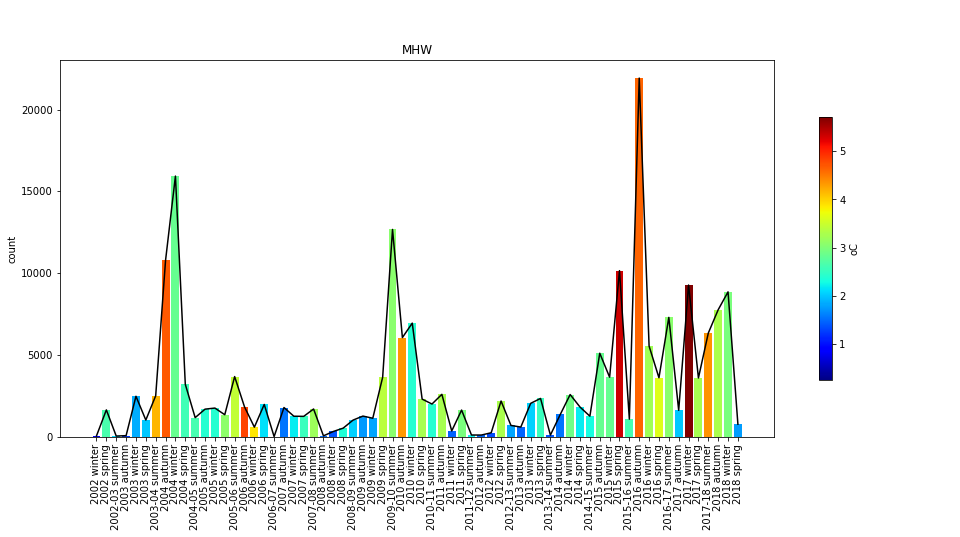

In [308]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF.index.values
y = seasonDF['count'].values
z1 = seasonDF['max'].values # display as colormap according to its values
z1_min = z1.min()
z1_max = z1.max()
z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

0.5050010681152344 6.0019989013671875


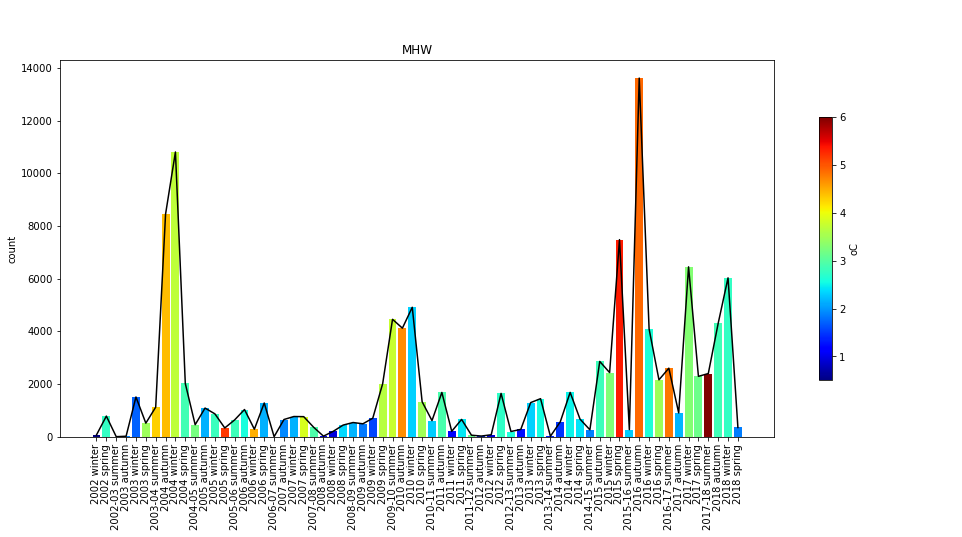

In [419]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF1.index.values
y = seasonDF1['count'].values
z1 = seasonDF1['max'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)
print(z1_min,z1_max)
z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

0.5050010681152344 6.0019989013671875


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  self.axes.set_ylim((ymin, ymax), auto=None)


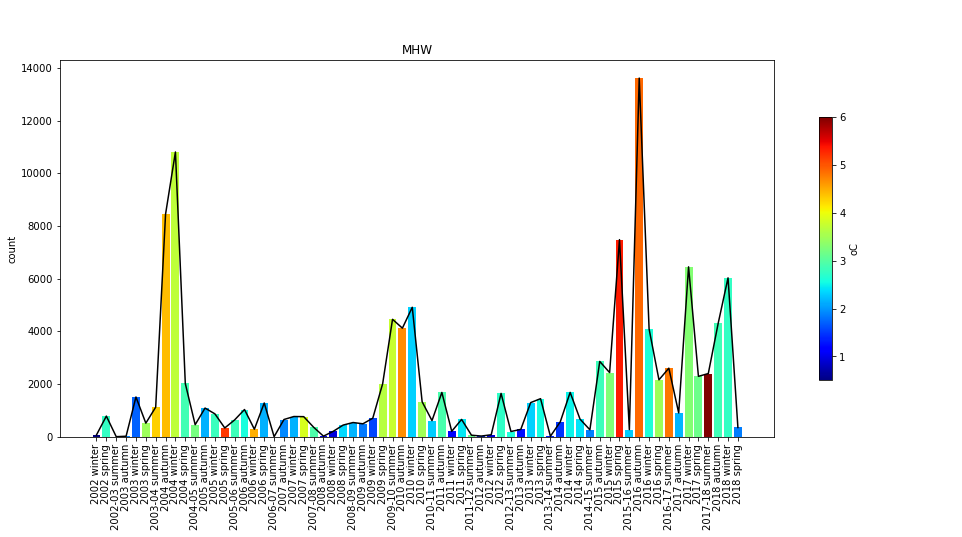

In [71]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF3.index.values
y = seasonDF3['count'].values
z1 = seasonDF3['max'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)
print(z1_min,z1_max)
z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  self.axes.set_ylim((ymin, ymax), auto=None)


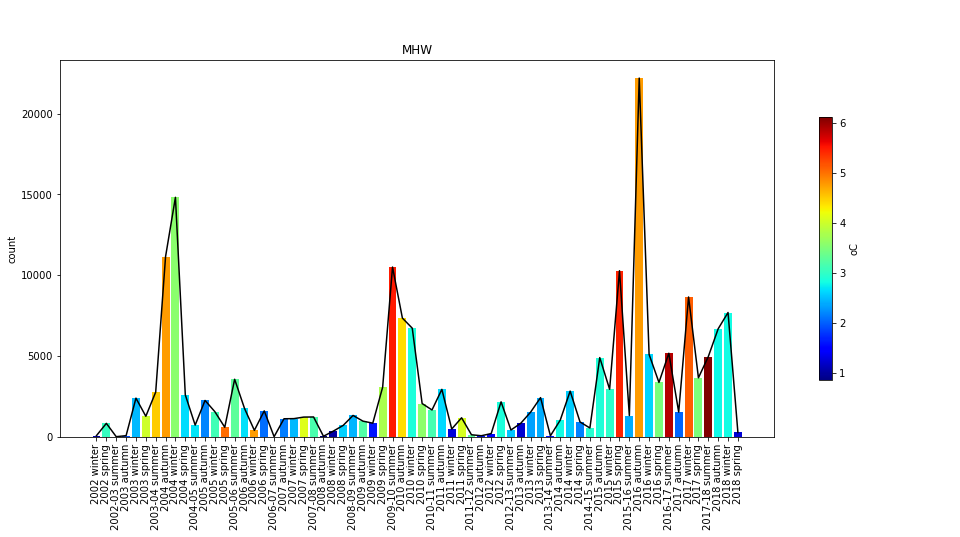

In [36]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
y = seasonDF4['count'].values
z1 = seasonDF4['max'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

**These codes could not accurately do what we want to show here**

0.17 0.7
0.23 0.6222222222222222
0.29 0.5444444444444444
0.35 0.4666666666666666
0.41 0.38888888888888884
0.47 0.31111111111111106
0.5299999999999999 0.23333333333333328
0.59 0.15555555555555545
0.6499999999999999 0.07777777777777772
0.71 0.0


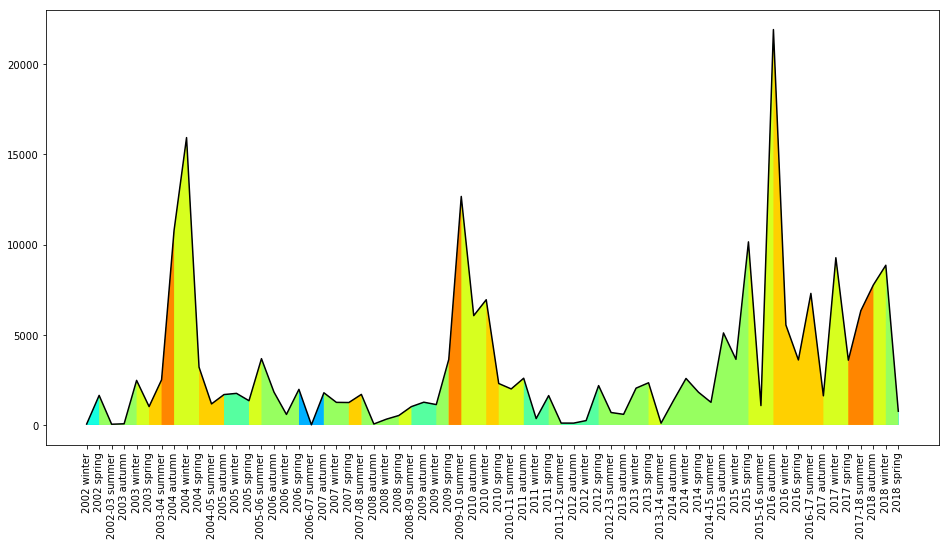

In [224]:
import matplotlib.ticker as ticker
import matplotlib

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
cmap = matplotlib.cm.get_cmap('jet_r')

x = seasonDF.index.values
y = seasonDF['count'].values
z = seasonDF['mean'].values

ax.plot(x, y, color='black', linestyle='-', marker='')
ax.fill_between(x, 0, y, where=z >= 0.17, facecolor=cmap(0.7), alpha=1)

for ii, thresh in enumerate(np.linspace(0.17, 0.71, 10)):    
    color_vals = np.linspace(0.7, 0, 10)
    print(thresh,color_vals[ii])
    ax.fill_between(x, 0, y, where=z >= thresh, facecolor=cmap(color_vals[ii]), alpha=1)

plt.show()

**Add the summary statistics into the 'data' as addiontal variables, so that we can display them 
as maps**

In [73]:
mhwDF3.set_index('pointID',inplace=True)

In [75]:
noEventsA = mhwDF3['noEvents'].values.reshape(90,40)
noDaysA = mhwDF3['noDays'].values.reshape(90,40)
totalIntensityA = mhwDF3['totalIntensity'].values.reshape(90,40)
overallIntensityA = mhwDF3['overallIntensity'].values.reshape(90,40)
highestIntensityA = mhwDF3['highestIntensity'].values.reshape(90,40)
date_start_HIA = mhwDF3['date_start_HI'].values.reshape(90,40)
largestDurationA = mhwDF3['largestDuration'].values.reshape(90,40)
date_start_LDA = mhwDF3['date_start_LD'].values.reshape(90,40)
intensityLDA = mhwDF3['intensityLD'].values.reshape(90,40)
largestMeanIntensityA = mhwDF3['largestMeanIntensity'].values.reshape(90,40)
date_start_LMIA = mhwDF3['date_start_LMI'].values.reshape(90,40)
duration_LMIA = mhwDF3['duration_LMI'].values.reshape(90,40)
largestCumIntensityA = mhwDF3['largestCumIntensity'].values.reshape(90,40)
date_start_LCIA = mhwDF3['date_start_LCI'].values.reshape(90,40)
duration_LCIA = mhwDF3['duration_LCI'].values.reshape(90,40)


In [76]:
data['noEvents'] = (('latitude','longitude'), noEventsA)
data['noDays'] = (('latitude','longitude'), noDaysA)
data['totalIntensity'] = (('latitude','longitude'), totalIntensityA)
data['overallIntensity'] = (('latitude','longitude'), overallIntensityA)
data['highestIntensity'] = (('latitude','longitude'), highestIntensityA)
data['date_start_HI'] = (('latitude','longitude'), date_start_HIA)
data['largestDuration'] = (('latitude','longitude'), largestDurationA)
data['date_start_LD'] = (('latitude','longitude'), date_start_LDA)
data['intensityLD'] = (('latitude','longitude'), intensityLDA)
data['largestMeanIntensity'] = (('latitude','longitude'), largestMeanIntensityA)
data['date_start_LMI'] = (('latitude','longitude'), date_start_LMIA)
data['duration_LMI'] = (('latitude','longitude'), duration_LMIA)
data['largestCumIntensity'] = (('latitude','longitude'), largestCumIntensityA)
data['date_start_LCI'] = (('latitude','longitude'), date_start_LCIA)
data['duration_LCI'] = (('latitude','longitude'), duration_LCIA)

In [153]:
testA = np.copy(mhwDF['date_start_HI'].values)

In [154]:
testA[testA > -1796] = 3
testA[testA < -1826] = 1


In [155]:
testA[testA < 0] = 2

In [156]:
testA=testA.reshape(90,40)
data['testSeason'] = (('latitude','longitude'), testA)

In [168]:
latlonDF.loc[2144]

id                   2145
lat                -32.35
lon    159.45000000000002
Name: 2144, dtype: object

In [77]:
data

<xarray.Dataset>
Dimensions:               (latitude: 90, longitude: 40, time: 5900)
Coordinates:
  * time                  (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2018-10-12T11:59:59.999999
  * latitude              (latitude) float64 -27.05 -27.15 ... -35.85 -35.95
  * longitude             (longitude) float64 157.1 157.2 157.2 ... 160.9 161.0
Data variables:
    sst                   (time, latitude, longitude) float32 nan nan ... nan
    noEvents              (latitude, longitude) int64 8 9 6 6 11 9 ... 7 6 4 6 6
    noDays                (latitude, longitude) int64 48 53 41 50 ... 23 32 36
    totalIntensity        (latitude, longitude) float64 27.53 28.61 ... 23.46
    overallIntensity      (latitude, longitude) float64 0.5736 0.5399 ... 0.6517
    highestIntensity      (latitude, longitude) float64 1.462 1.913 ... 1.588
    date_start_HI         (latitude, longitude) int64 -3948 -1801 ... -1497
    largestDuration       (latitude, longitude) int64 10 9 10 15 10 ... 

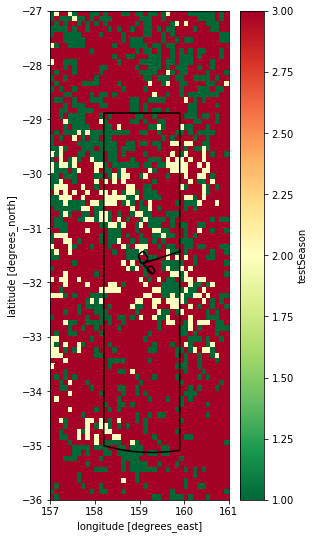

In [158]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(4,9))

#nor1_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('nor1: 20091115-20091121')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data.testSeason.plot(cmap='RdYlGn_r')

**Display the summary statistics as maps**

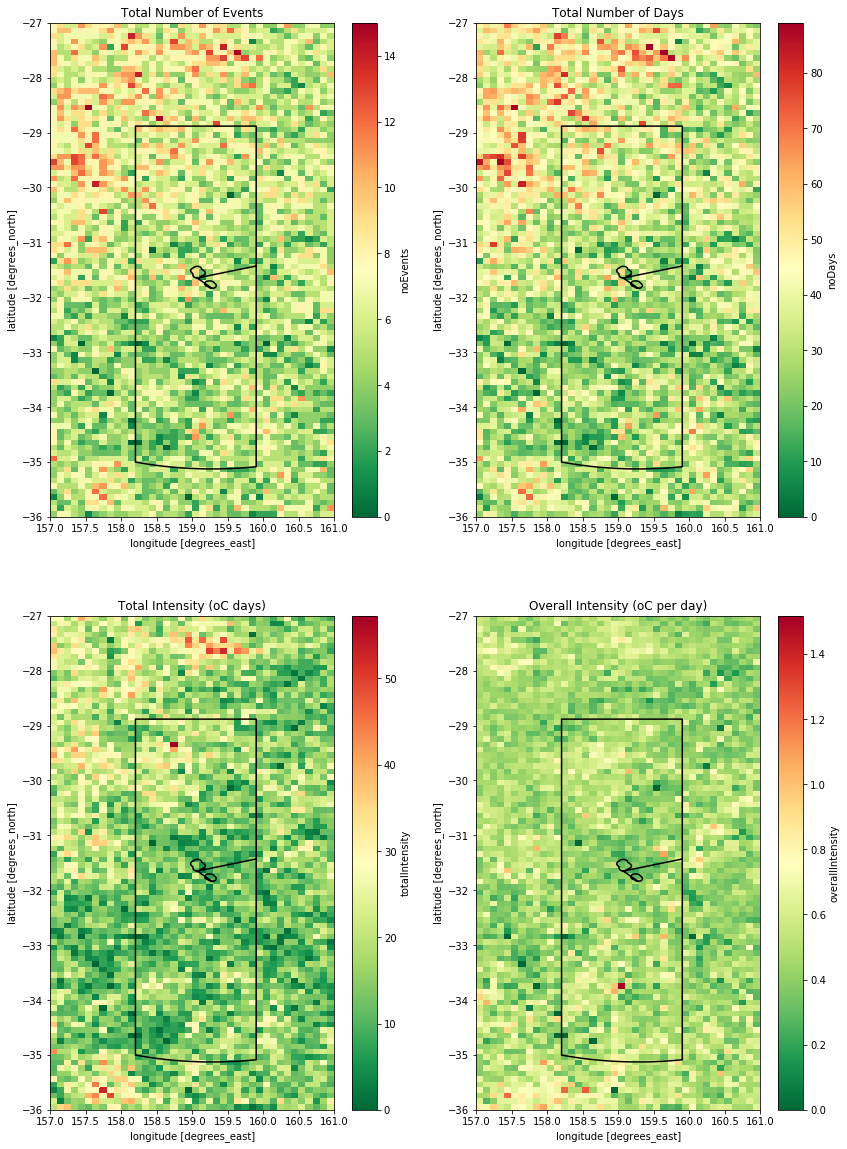

In [78]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.noEvents.plot(cmap='RdYlGn_r')
plt.title('Total Number of Events')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.noDays.plot(cmap='RdYlGn_r')
plt.title('Total Number of Days')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.totalIntensity.plot(cmap='RdYlGn_r')
plt.title('Total Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.overallIntensity.plot(cmap='RdYlGn_r')
plt.title('Overall Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()

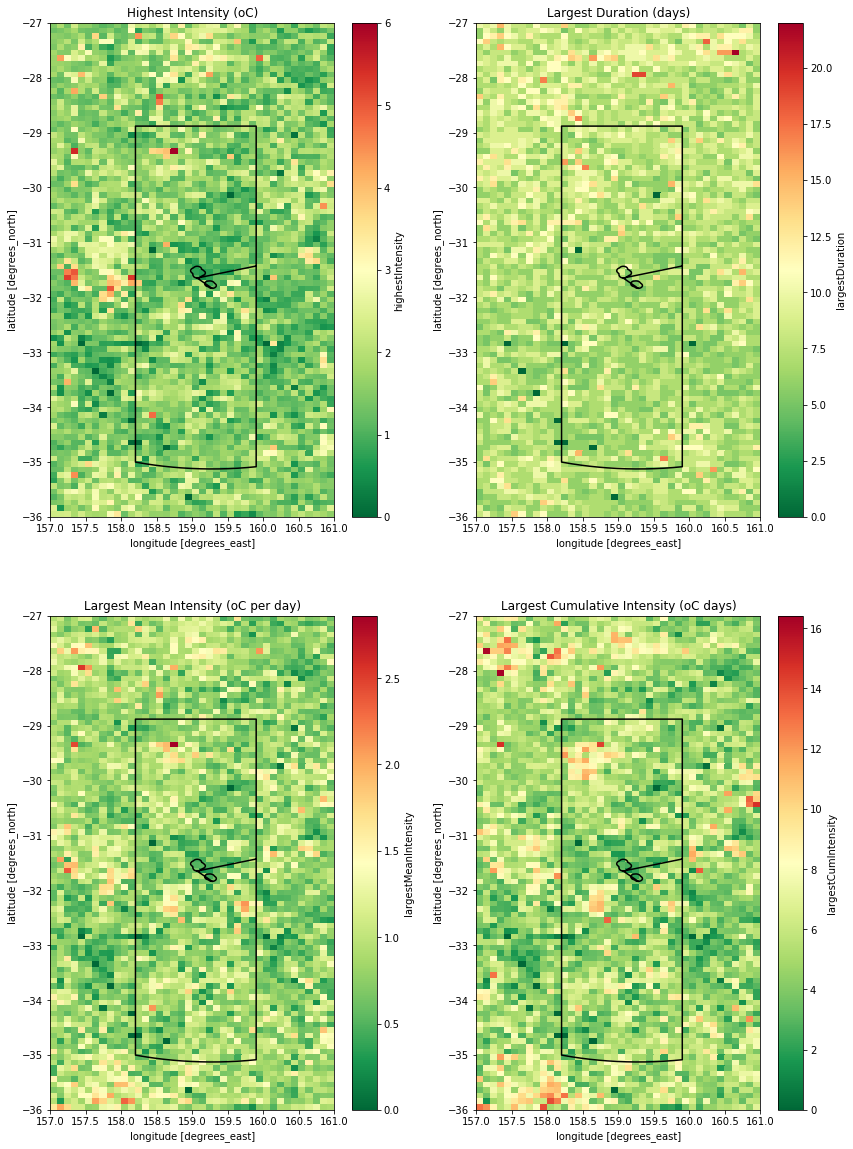

In [79]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.highestIntensity.plot(cmap='RdYlGn_r')
plt.title('Highest Intensity (oC)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.largestDuration.plot(cmap='RdYlGn_r')
plt.title('Largest Duration (days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.largestMeanIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Mean Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.largestCumIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Cumulative Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()
